# Beyond Visible Spectrum: AI for Agriculture 2026
> Beyond the limit

## Overview

Solve problems: 'Wheat Disease Recognition', use 3 type of images: 
- RGB: normal picture (3 kernels)
- MS: multispectral image (5 kernels)
- HS: hyperspectral image (128 kernels), after processing: ~101 kernels

In [13]:
import os, re, random
from dataclasses import dataclass
from typing import Dict, Optional, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import tifffile as tiff # read file tif (HS)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm # pretrained model

## Configuration

- HS has 125 bands, but after removing noisy bands (first: 10, last: 14), we use 101 bands.
- Resize all images to 224x224

In [ ]:
@dataclass
class CFG:
    # root directory and train, validation dir
    ROOT: str = "/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026/Kaggle_Prepared"  
    TRAIN_DIR: str = "train"
    VAL_DIR: str = "val"

    # flag for each image type
    USE_RGB: bool = True
    USE_MS: bool  = True
    USE_HS: bool  = True

    # image size for all
    IMG_SIZE: int = 224     # resize all image: 224x224

    # trainning hyperparameters
    BATCH_SIZE: int = 32  
    EPOCHS: int = 25
    LR: float = 3e-4        # 0.0003: learning rate
    WD: float = 1e-4        # 0.0001: weight decay or Norm2(L2) regularization

    NUM_WORKERS: int = 4    # number of workers for dataloader
    SEED: int = 1111        # constant seed number --> 1111

    RGB_BACKBONE: str = "convnext_base"  # backbone RGB, ConvNeXt, ImageNet
    AMP: bool = True        # automatic mixed precision (training faster)

    HS_DROP_FIRST: int = 10 # number of head bands -> drop
    HS_DROP_LAST: int = 14  # number of tail bands -> drop

    # save the result
    OUT_DIR: str = "/kaggle/working/"
    BEST_CKPT: str = "best.pt"

# label mapping
LABELS = ["Health", "Rust", "Other"]
LBL2ID = {k: i for i, k in enumerate(LABELS)} # Health -> 0, Rust -> 1, Other -> 2
ID2LBL = {i: k for k, i in LBL2ID.items()} 

## Data processing

- Indexing: 
```
{
    "Health_hyper_1": {
        "rgb": "train/RGB/Health_hyper_1.png",
        "ms":  "train/MS/Health_hyper_1.tif",
        "hs":  "train/HS/Health_hyper_1.tif"
    },
    "Rust_hyper_5": {
        "rgb": "train/RGB/Rust_hyper_5.png",
        "ms":  "train/MS/Rust_hyper_5.tif",
        "hs":  "train/HS/Rust_hyper_5.tif"
    }
}
```
- Create DataFrame: 
```
[base_id, label, rgb, ms, hs]
[
    [Health_hyper_1, Health, Health_hyper_1.png, Health_hyper_1.tif, Health_hyper_1.tif],
    [Rust_hyper_5, Rust, Rust_hyper_5.png, Rust_hyper_5.tif, Rust_hyper_5.tif]
]
```

- Stratified holdout: 
    - Train: 90%
    - Validation: 10%

In [15]:
# for reproducible result
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# get path of all file,sort
def list_files(folder: str, exts: Tuple[str, ...]) -> List[str]:
    if not os.path.isdir(folder):
        return []
    out = []
    for fn in os.listdir(folder):
        if fn.lower().endswith(exts):
            out.append(os.path.join(folder, fn))
    return sorted(out)

# get basename 
def base_id(path: str) -> str:
    return os.path.splitext(os.path.basename(path))[0]
# extract label from basename
def parse_label_from_train_name(bid: str) -> Optional[str]:
    m = re.match(r"^(Health|Rust|Other)_", bid)
    return m.group(1) if m else None

# indexing
def build_index(root: str, split: str) -> Dict[str, Dict[str, str]]:
    split_dir = os.path.join(root, split)
    rgb_dir = os.path.join(split_dir, "RGB")
    ms_dir  = os.path.join(split_dir, "MS")
    hs_dir  = os.path.join(split_dir, "HS")

    rgb_files = list_files(rgb_dir, (".png", ".jpg", ".jpeg"))
    ms_files  = list_files(ms_dir, (".tif", ".tiff"))
    hs_files  = list_files(hs_dir, (".tif", ".tiff"))

    idx: Dict[str, Dict[str, str]] = {}
    for p in rgb_files:
        idx.setdefault(base_id(p), {})["rgb"] = p
    for p in ms_files:
        idx.setdefault(base_id(p), {})["ms"] = p
    for p in hs_files:
        idx.setdefault(base_id(p), {})["hs"] = p
    return idx
# create data frame for training and validation
def make_train_df(train_idx: Dict[str, Dict[str, str]]) -> pd.DataFrame:
    rows = []
    for bid, paths in train_idx.items():
        lab = parse_label_from_train_name(bid)
        if lab is None:
            continue
        rows.append({
            "base_id": bid,
            "label": lab,
            "rgb": paths.get("rgb"),
            "ms":  paths.get("ms"),
            "hs":  paths.get("hs"),
        })
    return pd.DataFrame(rows)

def make_val_df(val_idx: Dict[str, Dict[str, str]]) -> pd.DataFrame:
    rows = []
    for bid, paths in val_idx.items():
        rows.append({
            "base_id": bid,
            "rgb": paths.get("rgb"),
            "ms":  paths.get("ms"),
            "hs":  paths.get("hs"),
        })
    return pd.DataFrame(rows)

# split train set to train & validation --> balance class
def stratified_holdout(df: pd.DataFrame, frac: float = 0.1, seed: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    parts = []
    for lab, g in df.groupby("label"):
        n = max(1, int(len(g) * frac))
        parts.append(g.iloc[:n])
    df_va = pd.concat(parts).drop_duplicates("base_id")
    df_tr = df[~df["base_id"].isin(df_va["base_id"])].reset_index(drop=True)
    df_va = df_va.reset_index(drop=True)
    return df_tr, df_va

## Read data and pre-processing images

- Read image: 
1. RGB: original (H, W, 3) unit8 [0-255]
    - -> BGR to RGB
    - -> normalize to [0-1]
    - -> Permute: (3, H, W)
    - -> ImageNet normalization

-> Output: Tensor (3, H, W) or (3, 224, 224), float32

2. MS: original (H, W, 5) unit8 [0-255]
    - -> normalize to [0-1]
    - -> Permute: (5, H, W)

3. HS: original (H, W, 125) unit16 [0-65535]
    - -> Remove noisy bands (first 10, last 14) -> (H, W, 101)
    - -> normalize to [0-1]
    - -> Permute: (101, H, W)

- Resize: 224x224 for all images
- Padding/Cropping: ensure all HS images have 101 bands

- Data augmentation: RandomHorizontalFlip, RandomVerticalFlip, RandomRotation(90)

In [16]:
# normalization constants: ImageNet 
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # (C, H, W) for broadcasting
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def fix_channels(x: torch.Tensor, target_c: int) -> torch.Tensor:
    # x: (C,H,W) -> (target_c,H,W) by crop or zero-pad
    c, h, w = x.shape
    if c == target_c:
        return x
    if c > target_c:
        return x[:target_c]
    pad = torch.zeros((target_c - c, h, w), dtype=x.dtype)
    return torch.cat([x, pad], dim=0)
    
def read_rgb(path: str) -> torch.Tensor:
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    x = torch.from_numpy(img).permute(2, 0, 1)  # numpy to torch tensor and (H, W, C) -> (C, H, W) = (3,H,W)
    x = (x - IMAGENET_MEAN) / IMAGENET_STD      # ImageNet normalization 
    return x

def read_tiff_multiband(path: str) -> np.ndarray:
    arr = tiff.imread(path)  # (H,W,C) or (C,H,W)
    if arr.ndim != 3:
        raise ValueError(f"Expected 3D TIFF, got {arr.shape} for {path}")
    if arr.shape[0] < arr.shape[1] and arr.shape[0] < arr.shape[2]:
        arr = np.transpose(arr, (1, 2, 0))  # -> (H,W,C)
    return arr

def normalize_per_band_minmax(x: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    H, W, C = x.shape
    flat = x.reshape(-1, C) # (H*W, C)
    mn = flat.min(axis=0)
    mx = flat.max(axis=0)
    denom = (mx - mn)
    denom[denom < eps] = 1.0
    x = (x - mn.reshape(1, 1, C)) / denom.reshape(1, 1, C)
    return np.clip(x, 0.0, 1.0)

def read_ms(path: str) -> torch.Tensor:
    arr = read_tiff_multiband(path)           # (H,W,5)
    arr = normalize_per_band_minmax(arr)
    return torch.from_numpy(arr).permute(2, 0, 1)  # (5,H,W)

def read_hs(path: str, drop_first: int, drop_last: int) -> torch.Tensor:
    arr = read_tiff_multiband(path)           # (H,W,B)
    B = arr.shape[2]
    if B > (drop_first + drop_last + 1):
        arr = arr[:, :, drop_first:B - drop_last]
    arr = normalize_per_band_minmax(arr)
    return torch.from_numpy(arr).permute(2, 0, 1)  # (B',H,W)

def resize_tensor(x: torch.Tensor, size: int) -> torch.Tensor:
    # x: (C,H,W) -> (C,size,size)
    return F.interpolate(x.unsqueeze(0), size=(size, size), mode="bilinear", align_corners=False).squeeze(0)

# augmentation : apply to all modalities
def apply_joint_aug(x_rgb, x_ms, x_hs):
    k = random.randint(0, 3)
    do_h = random.random() < 0.5
    do_v = random.random() < 0.5

    def _tf(x):
        if x is None:
            return None
        if k:
            x = torch.rot90(x, k, dims=(1, 2))
        if do_h:
            x = torch.flip(x, dims=(2,))
        if do_v:
            x = torch.flip(x, dims=(1,))
        return x

    return _tf(x_rgb), _tf(x_ms), _tf(x_hs)

def infer_hs_in_ch(df_train: pd.DataFrame, df_val: pd.DataFrame, cfg: CFG) -> int:
    for df in (df_train, df_val):
        if "hs" in df.columns:
            for p in df["hs"].dropna().tolist():
                if p and os.path.exists(p):
                    x = read_hs(p, cfg.HS_DROP_FIRST, cfg.HS_DROP_LAST)
                    return int(x.shape[0])
    return 101

## Handle missing modality

- Sample missing modality -> tensor zeros
- Mask vector [m_rgb, m_ms, m_hs]: 1 - available, 0 - missing
    - [1, 1, 1]: all available
    - [1, 1, 0]: missing HS
    - [1, 0, 1]: missing MS
    - ...

In [17]:
class WheatMultiModalDataset(Dataset):
    def __init__(self, df: pd.DataFrame, cfg: CFG, hs_in_ch: int, train: bool):
        self.df = df.reset_index(drop=True)
        self.cfg = cfg
        self.hs_in_ch = hs_in_ch
        self.train = train # flag traning mode (True) or inference (False)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i: int):
        row = self.df.iloc[i]
        bid = row["base_id"]

        x_rgb = x_ms = x_hs = None
        m_rgb = m_ms = m_hs = 0.0

        if self.cfg.USE_RGB and row.get("rgb") is not None:
            x_rgb = read_rgb(row["rgb"])
            x_rgb = resize_tensor(x_rgb, self.cfg.IMG_SIZE) # resize
            m_rgb = 1.0 # mark as available

        if self.cfg.USE_MS and row.get("ms") is not None:
            x_ms = read_ms(row["ms"])
            x_ms = resize_tensor(x_ms, self.cfg.IMG_SIZE)
            m_ms = 1.0


        if self.cfg.USE_HS and isinstance(row.get("hs"), str) and row["hs"]:
            x_hs = read_hs(row["hs"], self.cfg.HS_DROP_FIRST, self.cfg.HS_DROP_LAST)
            x_hs = fix_channels(x_hs, self.hs_in_ch) 
            x_hs = resize_tensor(x_hs, self.cfg.IMG_SIZE)
            m_hs = 1.0

        # augmentation for train only
        if self.train:
            x_rgb, x_ms, x_hs = apply_joint_aug(x_rgb, x_ms, x_hs)

        # missing modality: tensor zeros, mark as 0 
        if self.cfg.USE_RGB and x_rgb is None:
            x_rgb = torch.zeros(3, self.cfg.IMG_SIZE, self.cfg.IMG_SIZE, dtype=torch.float32)
        if self.cfg.USE_MS and x_ms is None:
            x_ms = torch.zeros(5, self.cfg.IMG_SIZE, self.cfg.IMG_SIZE, dtype=torch.float32)
        if self.cfg.USE_HS and x_hs is None:
            x_hs = torch.zeros(self.hs_in_ch, self.cfg.IMG_SIZE, self.cfg.IMG_SIZE, dtype=torch.float32)

        mask = torch.tensor([m_rgb, m_ms, m_hs], dtype=torch.float32)

        if "label" in row:
            y = LBL2ID[row["label"]]
            return {"id": bid, "rgb": x_rgb, "ms": x_ms, "hs": x_hs, "mask": mask, "y": torch.tensor(y, dtype=torch.long)}
        else:
            return {"id": bid, "rgb": x_rgb, "ms": x_ms, "hs": x_hs, "mask": mask}

## Model architecture

In [18]:
class SmallSpectralEncoder(nn.Module):
    def __init__(self, in_ch: int, emb_dim: int = 256):
        super().__init__()
        # input: (in_ch, H, W) -> output: (32, H, W)
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 32, kernel_size=1, bias=False),
            nn.BatchNorm2d(32), # normalize by batch dimension  
            nn.ReLU(inplace=True),
        )
        self.block = nn.Sequential(
            #--- Layer 1: increase channels
            #  (32, H, W) -> (64, H, W)
            #  - input_channels = 32
            #  - output_channels = 64 (number of filters)
            #  - kernel: (3x3)
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            #--- Layer 2: (64, H, W) -> (128, H, W)
            #  - input_channels = 64
            #  - output_channels = 128
            #  - kernel: (3x3)
            # nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.Conv2d(64, 128, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            #--- Layer 3:  deeper
            #  (128, H, W) -> (128, H, W)
            #  - input_channels = 128 
            #  - output_channels = 128
            #  - kernel: (3x3)
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, emb_dim),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.block(x)
        return self.head(x)

class MultiModalNet(nn.Module):
    def __init__(self, cfg: CFG, hs_in_ch: int, n_classes: int = 3):
        super().__init__()
        # flag
        self.use_rgb = cfg.USE_RGB
        self.use_ms  = cfg.USE_MS
        self.use_hs  = cfg.USE_HS

        # feature dimensions
        feat_dims = []

        # RGB
        if self.use_rgb:
            # RBG_BACKBONE: ConvNeXt-Base
            # pretrained=True -> load pretrained weights from ImageNet
            self.rgb_enc = timm.create_model(cfg.RGB_BACKBONE, pretrained=True, num_classes=0, global_pool="avg")
            rgb_dim = self.rgb_enc.num_features
            feat_dims.append(rgb_dim)
        else:
            self.rgb_enc = None

        # MS
        if self.use_ms:
            self.ms_enc = SmallSpectralEncoder(in_ch=5, emb_dim=256)
            feat_dims.append(256)
        else:
            self.ms_enc = None

        # HS
        if self.use_hs:
            self.hs_enc = SmallSpectralEncoder(in_ch=hs_in_ch, emb_dim=256)
            feat_dims.append(256)
        else:
            self.hs_enc = None

        # RBG_dim + MS_dim + HS_dim = (1024 + 256 + 256) = 1536
        fusion_dim = sum(feat_dims)
        self.classifier = nn.Sequential(
            # 
            nn.Linear(fusion_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes),
        )

    def forward(self, rgb, ms, hs, mask):
        feats = []
        if self.use_rgb:
            feats.append(self.rgb_enc(rgb) * mask[:, 0:1])
        if self.use_ms:
            feats.append(self.ms_enc(ms) * mask[:, 1:2])
        if self.use_hs:
            feats.append(self.hs_enc(hs) * mask[:, 2:3])

        f = torch.cat(feats, dim=1)
        return self.classifier(f)

## Training 

In [19]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total, correct = 0, 0
    conf = np.zeros((3, 3), dtype=np.int64)

    for batch in loader:
        rgb  = batch["rgb"].to(device)
        ms   = batch["ms"].to(device)
        hs   = batch["hs"].to(device)
        mask = batch["mask"].to(device)
        y    = batch["y"].to(device)

        logits = model(rgb, ms, hs, mask)
        pred = logits.argmax(dim=1)

        total += y.size(0)
        correct += (pred == y).sum().item()

        yt = y.cpu().numpy()
        yp = pred.cpu().numpy()
        for t, p in zip(yt, yp):
            conf[t, p] += 1

    acc = correct / max(1, total)

    f1s = []
    for c in range(3):
        tp = conf[c, c]
        fp = conf[:, c].sum() - tp
        fn = conf[c, :].sum() - tp
        prec = tp / max(1, (tp + fp))
        rec  = tp / max(1, (tp + fn))
        f1 = 0.0 if (prec + rec) == 0 else (2 * prec * rec / (prec + rec))
        f1s.append(f1)

    return {"acc": float(acc), "macro_f1": float(np.mean(f1s))}

def train_one_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss, n = 0.0, 0

    for batch in loader:
        rgb  = batch["rgb"].to(device)
        ms   = batch["ms"].to(device)
        hs   = batch["hs"].to(device)
        mask = batch["mask"].to(device)
        y    = batch["y"].to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            logits = model(rgb, ms, hs, mask)
            loss = F.cross_entropy(logits, y)

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        n += bs

    return total_loss / max(1, n)

@torch.no_grad()
def predict(model, loader, device):
    model.eval()
    preds = []
    ids = []
    for batch in loader:
        rgb  = batch["rgb"].to(device)
        ms   = batch["ms"].to(device)
        hs   = batch["hs"].to(device)
        mask = batch["mask"].to(device)

        logits = model(rgb, ms, hs, mask)
        p = logits.argmax(dim=1).cpu().numpy().tolist()
        preds.extend([ID2LBL[x] for x in p])
        ids.extend(batch["id"])
    return ids, preds


In [20]:
cfg = CFG()
seed_everything(cfg.SEED)
os.makedirs(cfg.OUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Backbone:", cfg.RGB_BACKBONE)

train_idx = build_index(cfg.ROOT, cfg.TRAIN_DIR)
val_idx   = build_index(cfg.ROOT, cfg.VAL_DIR)

train_df = make_train_df(train_idx)
val_df   = make_val_df(val_idx)

print(f"Indexed train IDs: {len(train_idx)} | usable labeled train rows: {len(train_df)}")
print(f"Indexed val IDs:   {len(val_idx)}   | val rows: {len(val_df)}")

if len(train_df) == 0:
    raise RuntimeError("No training samples found. Check ROOT/train and filename label pattern (Health_/Rust_/Other_).")

hs_in_ch = infer_hs_in_ch(train_df, val_df, cfg)
print("Inferred HS channels after trimming:", hs_in_ch)

df_tr, df_va = stratified_holdout(train_df, frac=0.1, seed=cfg.SEED)
print(f"Train split: {len(df_tr)} | Holdout split: {len(df_va)}")

ds_tr = WheatMultiModalDataset(df_tr, cfg, hs_in_ch=hs_in_ch, train=True)
ds_va = WheatMultiModalDataset(df_va, cfg, hs_in_ch=hs_in_ch, train=False)
ds_te = WheatMultiModalDataset(val_df, cfg, hs_in_ch=hs_in_ch, train=False)

dl_tr = DataLoader(ds_tr, batch_size=cfg.BATCH_SIZE, shuffle=True,
                   num_workers=cfg.NUM_WORKERS, pin_memory=True, drop_last=True)
dl_va = DataLoader(ds_va, batch_size=cfg.BATCH_SIZE, shuffle=False,
                   num_workers=cfg.NUM_WORKERS, pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=cfg.BATCH_SIZE, shuffle=False,
                   num_workers=cfg.NUM_WORKERS, pin_memory=True)

model = MultiModalNet(cfg, hs_in_ch=hs_in_ch, n_classes=3).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=cfg.WD)
scaler = torch.cuda.amp.GradScaler(enabled=(cfg.AMP and device.type == "cuda"))

best_f1 = -1.0
best_path = os.path.join(cfg.OUT_DIR, cfg.BEST_CKPT)

# Tracking metrics for plotting
history = {
    "epoch": [],
    "train_loss": [],
    "val_acc": [],
    "val_f1": [],
    "checkpoint_epochs": [], # Epochs where chpt was saved
    "checkpoint_f1": [],     # F1 scores at chpt epochs
}

for ep in range(1, cfg.EPOCHS + 1):
    tr_loss = train_one_epoch(model, dl_tr, optimizer, scaler if scaler.is_enabled() else None, device)
    metrics = evaluate(model, dl_va, device)
    print(f"Epoch {ep:02d} | loss={tr_loss:.4f} | val_acc={metrics['acc']:.4f} | val_macroF1={metrics['macro_f1']:.4f}")

    # Save history
    history["epoch"].append(ep)
    history["train_loss"].append(tr_loss)
    history["val_acc"].append(metrics["acc"])
    history["val_f1"].append(metrics["macro_f1"])
    
    if metrics["macro_f1"] > best_f1:
        best_f1 = metrics["macro_f1"]
        torch.save({"model": model.state_dict(), "hs_in_ch": hs_in_ch, "cfg": cfg.__dict__}, best_path)
        print(f"  -> saved best to {best_path}")
        # Mark checkpoint
        history["checkpoint_epochs"].append(ep)
        history["checkpoint_f1"].append(metrics["macro_f1"])

Device: cuda
Backbone: convnext_base
Indexed train IDs: 600 | usable labeled train rows: 600
Indexed val IDs:   300   | val rows: 300
Inferred HS channels after trimming: 101
Train split: 540 | Holdout split: 60


/tmp/ipykernel_55/2254701996.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.AMP and device.type == "cuda"))
/tmp/ipykernel_55/640892646.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 01 | loss=0.9887 | val_acc=0.5500 | val_macroF1=0.4741
  -> saved best to /kaggle/working/best.pt
Epoch 02 | loss=0.8600 | val_acc=0.5333 | val_macroF1=0.5174
  -> saved best to /kaggle/working/best.pt
Epoch 03 | loss=0.8361 | val_acc=0.6333 | val_macroF1=0.5738
  -> saved best to /kaggle/working/best.pt
Epoch 04 | loss=0.8001 | val_acc=0.6500 | val_macroF1=0.6104
  -> saved best to /kaggle/working/best.pt
Epoch 05 | loss=0.7261 | val_acc=0.5667 | val_macroF1=0.5627
Epoch 06 | loss=0.6481 | val_acc=0.6333 | val_macroF1=0.6044
Epoch 07 | loss=0.5735 | val_acc=0.6000 | val_macroF1=0.5833
Epoch 08 | loss=0.5297 | val_acc=0.5500 | val_macroF1=0.5254
Epoch 09 | loss=0.5824 | val_acc=0.6333 | val_macroF1=0.5786
Epoch 10 | loss=0.5459 | val_acc=0.5167 | val_macroF1=0.4968
Epoch 11 | loss=0.3767 | val_acc=0.6500 | val_macroF1=0.6000
Epoch 12 | loss=0.2848 | val_acc=0.6500 | val_macroF1=0.6528
  -> saved best to /kaggle/working/best.pt
Epoch 13 | loss=0.1976 | val_acc=0.5833 | val_macroF1

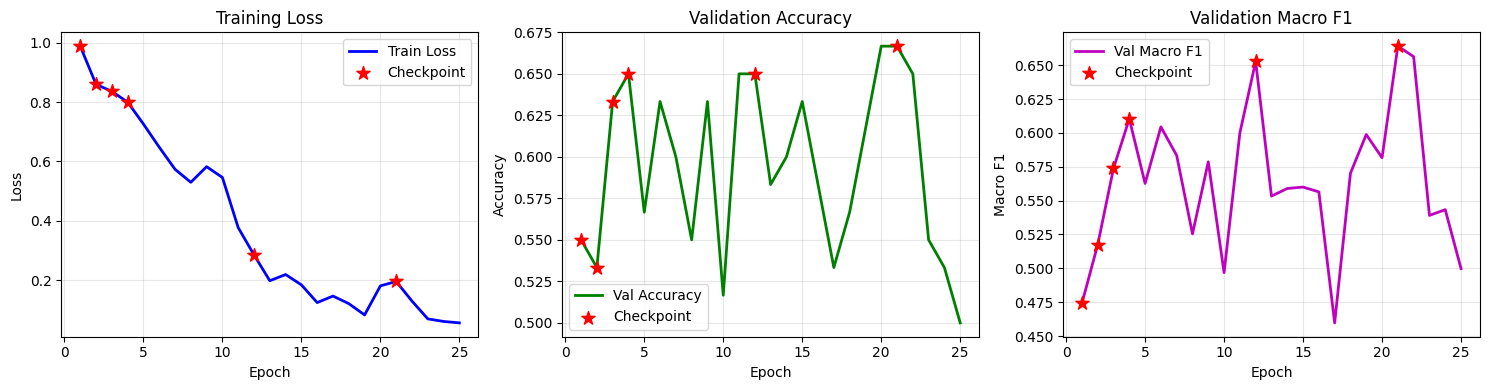


CHECKPOINT SUMMARY
  Checkpoint 1: Epoch 1, Macro F1 = 0.4741
  Checkpoint 2: Epoch 2, Macro F1 = 0.5174
  Checkpoint 3: Epoch 3, Macro F1 = 0.5738
  Checkpoint 4: Epoch 4, Macro F1 = 0.6104
  Checkpoint 5: Epoch 12, Macro F1 = 0.6528
  Checkpoint 6: Epoch 21, Macro F1 = 0.6640

Best checkpoint: Epoch 21, Macro F1 = 0.6640


In [21]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Training Loss
axes[0].plot(history["epoch"], history["train_loss"], 'b-', linewidth=2, label='Train Loss')
axes[0].scatter(history["checkpoint_epochs"], 
                [history["train_loss"][e-1] for e in history["checkpoint_epochs"]], 
                c='red', s=100, zorder=5, marker='*', label='Checkpoint')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy
axes[1].plot(history["epoch"], history["val_acc"], 'g-', linewidth=2, label='Val Accuracy')
axes[1].scatter(history["checkpoint_epochs"], 
                [history["val_acc"][e-1] for e in history["checkpoint_epochs"]], 
                c='red', s=100, zorder=5, marker='*', label='Checkpoint')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Validation Macro F1
axes[2].plot(history["epoch"], history["val_f1"], 'm-', linewidth=2, label='Val Macro F1')
axes[2].scatter(history["checkpoint_epochs"], history["checkpoint_f1"], 
                c='red', s=100, zorder=5, marker='*', label='Checkpoint')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Macro F1')
axes[2].set_title('Validation Macro F1')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(cfg.OUT_DIR, "training_curves.png"), dpi=150, bbox_inches='tight')
plt.show()

# Print checkpoint summary
print("\n" + "="*50)
print("CHECKPOINT SUMMARY")
print("="*50)
for i, (ep, f1) in enumerate(zip(history["checkpoint_epochs"], history["checkpoint_f1"]), 1):
    print(f"  Checkpoint {i}: Epoch {ep}, Macro F1 = {f1:.4f}")
print(f"\nBest checkpoint: Epoch {history['checkpoint_epochs'][-1]}, Macro F1 = {best_f1:.4f}")
print("="*50)


## Inference & summission

In [22]:
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"], strict=True)

pred_ids, pred_labels = predict(model, dl_te, device)


sub_ids = []
for _, r in val_df.iterrows():
    if isinstance(r.get("hs"), str) and r.get("hs"):
        sub_ids.append(os.path.basename(r["hs"]))
    elif isinstance(r.get("ms"), str) and r.get("ms"):
        sub_ids.append(os.path.basename(r["ms"]))
    else:
        sub_ids.append(os.path.basename(r["rgb"]))

In [23]:
sub = pd.DataFrame({"Id": sub_ids, "Category": pred_labels})
out_csv = os.path.join(cfg.OUT_DIR, "submission.csv")
sub.to_csv(out_csv, index=False)

In [24]:
sub.head(3)

,Id,Category
0,val_000a83c1.tif,Health
1,val_00a704b1.tif,Other
2,val_01dde030.tif,Health
